# Transformer Lens Main Demo Notebook

<b style="color: red">To use this notebook, go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.</b>

This is a reference notebook covering the main features of the [TransformerLens](https://github.com/neelnanda-io/TransformerLens) library for mechanistic interpretability. See [Callum McDougall's tutorial](https://transformerlens-intro.streamlit.app/TransformerLens_&_induction_circuits) for a more structured and gentler introduction to the library

**Tips for reading this Colab:**
* You can run all this code for yourself! 
* The graphs are interactive!
* Use the table of contents pane in the sidebar to navigate
* Collapse irrelevant sections with the dropdown arrows
* Search the page using the search in the sidebar, not CTRL+F

# Setup
(No need to read)

In [5]:
%cd ../
!bash setup.sh
%cd notebooks

/home/ec2-user/SageMaker/transformer-circuits
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/neelnanda-io/TransformerLens to /tmp/pip-req-build-l8p4zkc_
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens /tmp/pip-req-build-l8p4zkc_
  Resolved https://github.com/neelnanda-io/TransformerLens to commit 347e65235140d942301452a55505c9215b36806a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.2 MB/s eta 0:00:0000:0100:01
  Using cached einops-0.6.1-py3-none-any.whl (42 kB)
  Using cached circuitsvis-1.40.0-py3-none-any.whl (1.8 MB)
  Using cached plotly-5.15.0-py2.py3-none-any.whl (15.5 MB)
  Using cached fancy_einsum-0.0.3-py3-none-any.whl (6.2 kB)
  Using cached datasets-2.13.1-py3-none-any.whl (486 kB)
  Using cached dataclass

In [7]:
import torch
assert torch.cuda.is_available()

In [8]:
!curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
%pip install git+https://github.com/neelnanda-io/PySvelte.git


## Installing the NodeSource Node.js 16.x repo...


## Populating apt-get cache...

+ apt-get update
bash: apt-get: command not found
Error executing command, exiting
sudo: apt-get: command not found
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/neelnanda-io/PySvelte.git to /tmp/pip-req-build-ib9cxiz9
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/PySvelte.git /tmp/pip-req-build-ib9cxiz9
  Resolved https://github.com/neelnanda-io/PySvelte.git to commit 6f5d971a148d40fb7481d400ae74551b37340e83
  Preparing metadata (setup.py) ... done
  Created wheel for PySvelte: filename=PySvelte-1.0.0-py3-none-any.whl size=158308 sha256=1a1f8c8d90d2d2a6c0376e8bc4ec009a0f6e8dd98cfed9b6c512174500bd8e13
  Stored in directory: /tmp/pip-ephem-wheel-cache-kec9q6gx/wheels/b1/62/1a/a09a9383744fd48b0f376bc0954a5b9aab04d1c3f5929d3913
Successfully built PySvelte
  Attempting uninstall: typeguard
    Found 

In [9]:

# PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
# # Install another version of node that makes PySvelte work way faster

from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the HookedTransformer code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

In [48]:
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'browser'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [49]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = "jupyterlab"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: jupyterlab


In [36]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
from matplotlib import pyplot as plt

In [14]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [15]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [37]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)
    plt.show()

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

# Introduction

This is a demo notebook for [TransformerLens](https://github.com/neelnanda-io/TransformerLens), **a library I ([Neel Nanda](neelnanda.io)) wrote for doing [mechanistic interpretability](https://distill.pub/2020/circuits/zoom-in/) of GPT-2 Style language models.**


The core design principle I've followed is to enable exploratory analysis - one of the most fun parts of mechanistic interpretability compared to normal ML is the extremely short feedback loops! The point of this library is to keep the gap between having an experiment idea and seeing the results as small as possible, to make it easy for **research to feel like play** and to enter a flow state. This notebook demonstrates how the library works and how to use it, but if you want to see how well it works for exploratory research, check out [my notebook analysing Indirect Objection Identification](https://neelnanda.io/exploratory-analysis-demo) or [my recording of myself doing research](https://www.youtube.com/watch?v=yo4QvDn-vsU)!

## Loading and Running Models

TransformerLens comes loaded with >40 open source GPT-style models. You can load any of them in with `HookedTransformer.from_pretrained(MODEL_NAME)`. For this demo notebook we'll look at GPT-2 Small, an 80M parameter model, see the Available Models section for info on the rest.

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


To try the model out, let's find the loss on this text! Models can be run on a single string or a tensor of tokens (shape: [batch, position], all integers), and the possible return types are: 
* "logits" (shape [batch, position, d_vocab], floats), 
* "loss" (the cross-entropy loss when predicting the next token), 
* "both" (a tuple of (logits, loss)) 
* None (run the model, but don't calculate the logits - this is faster when we only want to use intermediate activations)

In [10]:
model_description_text = """## Loading Models

HookedTransformer comes loaded with >40 open source GPT-style models. You can load any of them in with `HookedTransformer.from_pretrained(MODEL_NAME)`. See my explainer for documentation of all supported models, and this table for hyper-parameters and the name used to load them. Each model is loaded into the consistent HookedTransformer architecture, designed to be clean, consistent and interpretability-friendly. 

For this demo notebook we'll look at GPT-2 Small, an 80M parameter model. To try the model the model out, let's find the loss on this paragraph!"""
loss = model(model_description_text, return_type="loss")
print("Model loss:", loss)

Model loss: tensor(4.1758)


## Caching all Activations

The first basic operation when doing mechanistic interpretability is to break open the black box of the model and look at all of the internal activations of a model. This can be done with `logits, cache = model.run_with_cache(tokens)`. Let's try this out on the first line of the abstract of the GPT-2 paper.

<details><summary>On `remove_batch_dim`</summary>

Every activation inside the model begins with a batch dimension. Here, because we only entered a single batch dimension, that dimension is always length 1 and kinda annoying, so passing in the `remove_batch_dim=True` keyword removes it. `gpt2_cache_no_batch_dim = gpt2_cache.remove_batch_dim()` would have achieved the same effect.
</details?>

In [21]:
gpt2_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
gpt2_tokens = model.to_tokens(gpt2_text)
print(gpt2_tokens.device)
gpt2_logits, gpt2_cache = model.run_with_cache(gpt2_tokens, remove_batch_dim=True)

cuda:0


In [22]:
gpt2_tokens

tensor([[50256, 35364,  3303,  7587,  8861,    11,   884,   355,  1808, 18877,
            11,  4572, 11059,    11,  3555, 35915,    11,   290, 15676,  1634,
            11,   389,  6032, 10448,   351, 28679,  4673,   319,  8861,   431,
          7790, 40522,    13]], device='cuda:0')

In [23]:
gpt2_logits

tensor([[[ 7.5261, 11.1214,  7.8919,  ..., -3.1299, -3.3873,  8.5934],
         [ 4.4261,  5.2600,  2.1652,  ...,  0.4973, -2.2385,  4.2680],
         [ 8.7212,  7.1920,  3.2337,  ...,  2.7380,  0.2224,  7.2776],
         ...,
         [ 4.8818,  6.6848,  2.6623,  ...,  4.4694, -1.5021,  5.2525],
         [ 7.4928,  8.2157,  3.5746,  ...,  1.5305, -0.2660,  7.6360],
         [ 4.6322,  5.0510,  5.8710,  ..., -1.5175, -6.7258, 13.3053]]],
       device='cuda:0')

Let's visualize the attention pattern of all the heads in layer 0, using [Alan Cooney's CircuitsVis library](https://github.com/alan-cooney/CircuitsVis) (based on [Anthropic's PySvelte library](https://github.com/anthropics/PySvelte)). 

We look this the attention pattern in `gpt2_cache`, an `ActivationCache` object, by entering in the name of the activation, followed by the layer index (here, the activation is called "attn" and the layer index is 0). This has shape [head_index, destination_position, source_position], and we use the `model.to_str_tokens` method to convert the text to a list of tokens as strings, since there is an attention weight between each pair of tokens.

This visualization is interactive! Try hovering over a token or head, and click to lock. The grid on the top left and for each head is the attention pattern as a destination position by source position grid. It's lower triangular because GPT-2 has **causal attention**, attention can only look backwards, so information can only move forwards in the network.

See the ActivationCache section for more on what `gpt2_cache` can do.

In [24]:
print(type(gpt2_cache))
attention_pattern = gpt2_cache["pattern", 0, "attn"]
print(attention_pattern.shape)
gpt2_str_tokens = model.to_str_tokens(gpt2_text)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 33, 33])


In [25]:
print("Layer 0 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=gpt2_str_tokens, attention=attention_pattern)

Layer 0 Head Attention Patterns:


## Hooks: Intervening on Activations

One of the great things about interpreting neural networks is that we have *full control* over our system. From a computational perspective, we know exactly what operations are going on inside (even if we don't know what they mean!). And we can make precise, surgical edits and see how the model's behaviour and other internals change. This is an extremely powerful tool, because it can let us eg set up careful counterfactuals and causal intervention to easily understand model behaviour. 

Accordingly, being able to do this is a pretty core operation, and this is one of the main things TransformerLens supports! The key feature here is **hook points**. Every activation inside the transformer is surrounded by a hook point, which allows us to edit or intervene on it. 

We do this by adding a **hook function** to that activation. The hook function maps `current_activation_value, hook_point` to `new_activation_value`. As the model is run, it computes that activation as normal, and then the hook function is applied to compute a replacement, and that is substituted in for the activation. The hook function can be an arbitrary Python function, so long as it returns a tensor of the correct shape.

<details><summary>Relationship to PyTorch hooks</summary>

[PyTorch hooks](https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/) are a great and underrated, yet incredibly janky, feature. They can act on a layer, and edit the input or output of that layer, or the gradient when applying autodiff. The key difference is that **Hook points** act on *activations* not layers. This means that you can intervene within a layer on each activation, and don't need to care about the precise layer structure of the transformer. And it's immediately clear exactly how the hook's effect is applied. This adjustment was shamelessly inspired by [Garcon's use of ProbePoints](https://transformer-circuits.pub/2021/garcon/index.html).

They also come with a range of other quality of life improvements, like the model having a `model.reset_hooks()` method to remove all hooks, or helper methods to temporarily add hooks for a single forward pass - it is *incredibly* easy to shoot yourself in the foot with standard PyTorch hooks!
</details>

As a basic example, let's [ablate](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=fh-HJyz1CgUVrXuoiban6bYx) head 7 in layer 0 on the text above. 

We define a `head_ablation_hook` function. This takes the value tensor for attention layer 0, and sets the component with `head_index==7` to zero and returns it (Note - we return by convention, but since we're editing the activation in-place, we don't strictly *need* to).

We then use the `run_with_hooks` helper function to run the model and *temporarily* add in the hook for just this run. We enter in the hook as a tuple of the activation name (also the hook point name - found with `utils.get_act_name`) and the hook function.

In [14]:
layer_to_ablate = 0
head_index_to_ablate = 8

# We define a head ablation hook
# The type annotations are NOT necessary, they're just a useful guide to the reader
# 
def head_ablation_hook(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    print(f"Shape of the value tensor: {value.shape}")
    value[:, :, head_index_to_ablate, :] = 0.
    return value

original_loss = model(gpt2_tokens, return_type="loss")
ablated_loss = model.run_with_hooks(
    gpt2_tokens, 
    return_type="loss", 
    fwd_hooks=[(
        utils.get_act_name("v", layer_to_ablate), 
        head_ablation_hook
        )]
    )
print(f"Original Loss: {original_loss.item():.3f}")
print(f"Ablated Loss: {ablated_loss.item():.3f}")

Shape of the value tensor: torch.Size([1, 33, 12, 64])
Original Loss: 3.999
Ablated Loss: 5.453


**Gotcha:** Hooks are global state - they're added in as part of the model, and stay there until removed. `run_with_hooks` tries to create an abstraction where these are local state, by removing all hooks at the end of the function. But you can easily shoot yourself in the foot if there's, eg, an error in one of your hooks so the function never finishes. If you start getting bugs, try `model.reset_hooks()` to clean things up. Further, if you *do* add hooks of your own that you want to keep, which you can do with `add_perma_hook` on the relevant HookPoint

### Activation Patching on the Indirect Object Identification Task

For a somewhat more involved example, let's use hooks to apply **[activation patching](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx)** on the **[Indirect Object Identification](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=iWsV3s5Kdd2ca3zNgXr5UPHa)** (IOI) task. 

The IOI task is the task of identifying that a sentence like "After John and Mary went to the store, Mary gave a bottle of milk to" continues with " John" rather than " Mary" (ie, finding the indirect object), and Redwood Research have [an excellent paper studying the underlying circuit in GPT-2 Small](https://arxiv.org/abs/2211.00593).

**[Activation patching](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx)** is a technique from [Kevin Meng and David Bau's excellent ROME paper](https://rome.baulab.info/). The goal is to identify which model activations are important for completing a task. We do this by setting up a **clean prompt** and a **corrupted prompt** and a **metric** for performance on the task. We then pick a specific model activation, run the model on the corrupted prompt, but then *intervene* on that activation and patch in its value when run on the clean prompt. We then apply the metric, and see how much this patch has recovered the clean performance. 
(See [a more detailed demonstration of activation patching here](https://colab.research.google.com/github.com/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb))

Here, our clean prompt is "After John and Mary went to the store, **Mary** gave a bottle of milk to", our corrupted prompt is "After John and Mary went to the store, **John** gave a bottle of milk to", and our metric is the difference between the correct logit ( John) and the incorrect logit ( Mary) on the final token. 

We see that the logit difference is significantly positive on the clean prompt, and significantly negative on the corrupted prompt, showing that the model is capable of doing the task!

In [26]:
clean_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
corrupted_prompt = "After John and Mary went to the store, John gave a bottle of milk to"

clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)

def logits_to_logit_diff(logits, correct_answer=" John", incorrect_answer=" Mary"):
    # model.to_single_token maps a string value of a single token to the token index for that token
    # If the string is not a single token, it raises an error.
    correct_index = model.to_single_token(correct_answer)
    incorrect_index = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

# We run on the clean prompt with the cache so we store activations to patch in later.
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

# We don't need to cache on the corrupted prompt.
corrupted_logits = model(corrupted_tokens)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

Clean logit difference: 4.276
Corrupted logit difference: -2.738


We now setup the hook function to do activation patching. Here, we'll patch in the [residual stream](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=DHp9vZ0h9lA9OCrzG2Y3rrzH) at the start of a specific layer and at a specific position. This will let us see how much the model is using the residual stream at that layer and position to represent the key information for the task. 

We want to iterate over all layers and positions, so we write the hook to take in an position parameter. Hook functions must have the input signature (activation, hook), but we can use `functools.partial` to set the position parameter before passing it to `run_with_hooks`

In [28]:
clean_tokens

tensor([[50256,  3260,  1757,   290,  5335,  1816,   284,   262,  3650,    11,
          5335,  2921,   257,  9294,   286,  7545,   284]], device='cuda:0')

In [29]:
# We define a residual stream patching hook
# We choose to act on the residual stream at the start of the layer, so we call it resid_pre
# The type annotations are a guide to the reader and are not necessary
def residual_stream_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
    position: int
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    clean_resid_pre = clean_cache[hook.name]
    resid_pre[:, position, :] = clean_resid_pre[:, position, :]
    return resid_pre

# We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
num_positions = len(clean_tokens[0])
ioi_patching_result = torch.zeros((model.cfg.n_layers, num_positions), device=model.cfg.device)

for layer in tqdm.tqdm(range(model.cfg.n_layers)):
    for position in range(num_positions):
        # Use functools.partial to create a temporary hook function with the position fixed
        temp_hook_fn = partial(residual_stream_patching_hook, position=position)
        # Run the model with the patching hook
        patched_logits = model.run_with_hooks(corrupted_tokens, fwd_hooks=[
            (utils.get_act_name("resid_pre", layer), temp_hook_fn)
        ])
        # Calculate the logit difference
        patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
        # Store the result, normalizing by the clean and corrupted logit difference so it's between 0 and 1 (ish)
        ioi_patching_result[layer, position] = (patched_logit_diff - corrupted_logit_diff)/(clean_logit_diff - corrupted_logit_diff)

  0%|          | 0/12 [00:00<?, ?it/s]

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)
    plt.show()

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)We can now visualize the results, and see that this computation is extremely localised within the model. Initially, the second subject (Mary) token is all that matters (naturally, as it's the only different token), and all relevant information remains here until heads in layer 7 and 8 move this to the final token where it's used to predict the indirect object.
(Note - the heads are in layer 7 and 8, not 8 and 9, because we patched in the residual stream at the *start* of each layer)

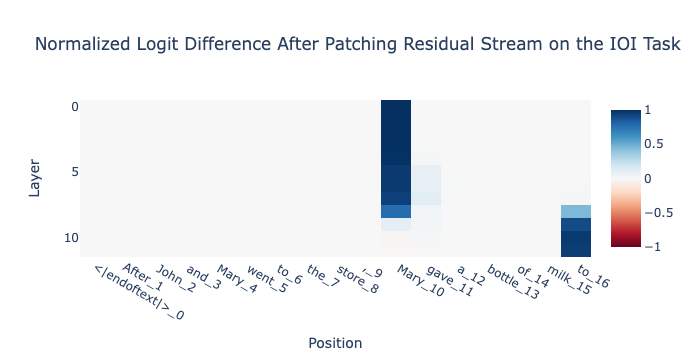

In [51]:
# %matplotlib inline
# Add the index to the end of the label, because plotly doesn't like duplicate labels
token_labels = [f"{token}_{index}" for index, token in enumerate(model.to_str_tokens(clean_tokens))]
imshow(ioi_patching_result, x=token_labels, xaxis="Position", yaxis="Layer", title="Normalized Logit Difference After Patching Residual Stream on the IOI Task")


## Hooks: Accessing Activations

Hooks can also be used to just **access** an activation - to run some function using that activation value, *without* changing the activation value. This can be achieved by just having the hook return nothing, and not editing the activation in place. 

This is useful for eg extracting activations for a specific task, or for doing some long-running calculation across many inputs, eg finding the text that most activates a specific neuron. (Note - everything this can do *could* be done with `run_with_cache` and post-processing, but this workflow can be more intuitive and memory efficient.)

To demonstrate this, let's look for **[induction heads](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html)** in GPT-2 Small. 

Induction circuits are a very important circuit in generative language models, which are used to detect and continue repeated subsequences. They consist of two heads in separate layers that compose together, a **previous token head** which always attends to the previous token, and an **induction head** which attends to the token *after* an earlier copy of the current token. 

To see why this is important, let's say that the model is trying to predict the next token in a news article about Michael Jordan. The token " Michael", in general, could be followed by many surnames. But an induction head will look from that occurence of " Michael" to the token after previous occurences of " Michael", ie " Jordan" and can confidently predict that that will come next.

An interesting fact about induction heads is that they generalise to arbitrary sequences of repeated tokens. We can see this by generating sequences of 50 random tokens, repeated twice, and plotting the average loss at predicting the next token, by position. We see that the model goes from terrible to very good at the halfway point.

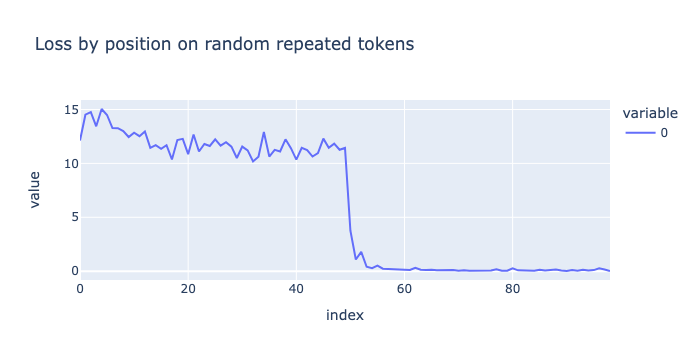

In [52]:
batch_size = 10
seq_len = 50
random_tokens = torch.randint(1000, 10000, (batch_size, seq_len)).to(model.cfg.device)
repeated_tokens = einops.repeat(random_tokens, "batch seq_len -> batch (2 seq_len)")
repeated_logits = model(repeated_tokens)
correct_log_probs = model.loss_fn(repeated_logits, repeated_tokens, per_token=True)
loss_by_position = einops.reduce(correct_log_probs, "batch position -> position", "mean")
line(loss_by_position, xaxis="Position", yaxis="Loss", title="Loss by position on random repeated tokens")

The induction heads will be attending from the second occurence of each token to the token *after* its first occurence, ie the token `50-1==49` places back. So by looking at the average attention paid 49 tokens back, we can identify induction heads! Let's define a hook to do this!

<details><summary>Technical details</summary>

* We attach the hook to the attention pattern activation. There's one big pattern activation per layer, stacked across all heads, so we need to do some tensor manipulation to get a per-head score. 
* Hook functions can access global state, so we make a big tensor to store the induction head score for each head, and then we just add the score for each head to the appropriate position in the tensor. 
* To get a single hook function that works for each layer, we use the `hook.layer()` method to get the layer index (internally this is just inferred from the hook names).
* As we want to add this to *every* activation pattern hook point, rather than giving the string for an activation name, this time we give a **name filter**. This is a Boolean function on hook point names, and it adds the hook function to every hook point where the function evaluates as true. 
    * `run_with_hooks` allows us to enter a list of (act_name, hook_function) pairs to all be added at once, so we could also have done this by inputting a list with a hook for each layer.
</details>

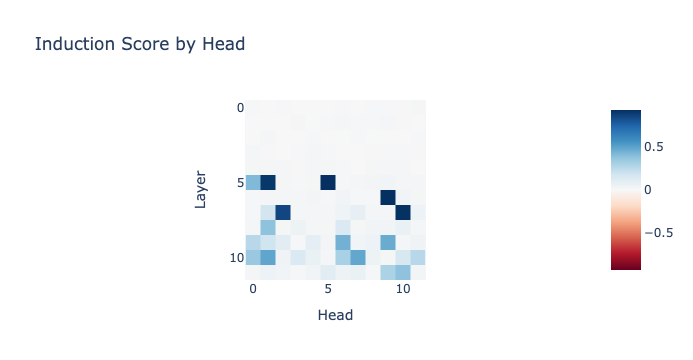

In [63]:
# We make a tensor to store the induction score for each head. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)
def induction_score_hook(
    pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    # We take the diagonal of attention paid from each destination position to source positions seq_len-1 tokens back
    # (This only has entries for tokens with index>=seq_len)
    induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1-seq_len)
    # Get an average score per head
    induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
    # Store the result.
    induction_score_store[hook.layer(), :] = induction_score

# We make a boolean filter on activation names, that's true only on attention pattern names.
pattern_hook_names_filter = lambda name: name.endswith("pattern")

model.run_with_hooks(
    repeated_tokens, 
    return_type=None, # For efficiency, we don't need to calculate the logits
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

imshow(induction_score_store, xaxis="Head", yaxis="Layer", title="Induction Score by Head")

Head 5 in Layer 5 scores extremely highly on this score, and we can feed in a shorter repeated random sequence, visualize the attention pattern for it and see this directly - including the "induction stripe" at `seq_len-1` tokens back.

This time we put in a hook on the attention pattern activation to visualize the pattern of the relevant head.

In [64]:
induction_head_layer = 5
induction_head_index = 5
single_random_sequence = torch.randint(1000, 10000, (1, 20)).to(model.cfg.device)
repeated_random_sequence = einops.repeat(single_random_sequence, "batch seq_len -> batch (2 seq_len)")
def visualize_pattern_hook(
    pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    display(
        cv.attention.attention_patterns(
            tokens=model.to_str_tokens(repeated_random_sequence), 
            attention=pattern[0, induction_head_index, :, :][None, :, :] # Add a dummy axis, as CircuitsVis expects 3D patterns.
        )
    )

model.run_with_hooks(
    repeated_random_sequence, 
    return_type=None, 
    fwd_hooks=[(
        utils.get_act_name("pattern", induction_head_layer), 
        visualize_pattern_hook
    )]
)

## Available Models

TransformerLens comes with over 40 open source models available, all of which can be loaded into a consistent(-ish) architecture by just changing the name in `from_pretrained`. The open source models available are [documented here](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=jHj79Pj58cgJKdq4t-ygK-4h), and a set of interpretability friendly models I've trained are [documented here](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=NCJ6zH_Okw_mUYAwGnMKsj2m), including a set of toy language models (tiny one to four layer models) and a set of [SoLU models](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=FZ5W6GGcy6OitPEaO733JLqf) up to GPT-2 Medium size (300M parameters). You can see [a table of the official alias and hyper-parameters of available models here](https://github.com/neelnanda-io/TransformerLens/blob/main/transformer_lens/model_properties_table.md).

**Note:** TransformerLens does not currently support multi-GPU models (which you want for models above eg 7B parameters), but this feature is coming soon!


Notably, this means that analysis can be near immediately re-run on a different model by just changing the name - to see this, let's load in DistilGPT-2 (a distilled version of GPT-2, with half as many layers) and copy the code from above to see the induction heads in that model.

In [34]:
distilgpt2 = HookedTransformer.from_pretrained("distilgpt2")
# We make a tensor to store the induction score for each head. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
distilgpt2_induction_score_store = torch.zeros((distilgpt2.cfg.n_layers, distilgpt2.cfg.n_heads), device=distilgpt2.cfg.device)
def induction_score_hook(
    pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    # We take the diagonal of attention paid from each destination position to source positions seq_len-1 tokens back
    # (This only has entries for tokens with index>=seq_len)
    induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1-seq_len)
    # Get an average score per head
    induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
    # Store the result.
    distilgpt2_induction_score_store[hook.layer(), :] = induction_score

# We make a boolean filter on activation names, that's true only on attention pattern names.
pattern_hook_names_filter = lambda name: name.endswith("pattern")

distilgpt2.run_with_hooks(
    repeated_tokens, 
    return_type=None, # For efficiency, we don't need to calculate the logits
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

imshow(distilgpt2_induction_score_store, xaxis="Head", yaxis="Layer", title="Induction Score by Head in Distil GPT-2")
plt.show()

Using pad_token, but it is not set yet.


Loaded pretrained model distilgpt2 into HookedTransformer


NameError: name 'plt' is not defined


### An overview of the important open source models in the library

* **GPT-2** - the classic generative pre-trained models from OpenAI
    * Sizes Small (85M), Medium (300M), Large (700M) and XL (1.5B).
    * Trained on ~22B tokens of internet text. ([Open source replication](https://huggingface.co/datasets/openwebtext))
* **GPT-Neo** - Eleuther's replication of GPT-2
    * Sizes 125M, 1.3B, 2.7B
    * Trained on 300B(ish?) tokens of [the Pile](https://pile.eleuther.ai/) a large and diverse dataset including a bunch of code (and weird stuff)
* **[OPT](https://ai.facebook.com/blog/democratizing-access-to-large-scale-language-models-with-opt-175b/)** - Meta AI's series of open source models
    * Trained on 180B tokens of diverse text.
    * 125M, 1.3B, 2.7B, 6.7B, 13B, 30B, 66B
* **GPT-J** - Eleuther's 6B parameter model, trained on the Pile
* **GPT-NeoX** - Eleuther's 20B parameter model, trained on the Pile
* **Stanford CRFM models** - a replication of GPT-2 Small and GPT-2 Medium, trained on 5 different random seeds.
    * Notably, 600 checkpoints were taken during training per model, and these are available in the library with eg `HookedTransformer.from_pretrained("stanford-gpt2-small-a", checkpoint_index=265)`.
- **BERT** - Google's bidirectional encoder-only transformer.
    - Size Base (108M), trained on English Wikipedia and BooksCorpus.
 
</details>


### An overview of some interpretability-friendly models I've trained and included

(Feel free to [reach out](mailto:neelnanda27@gmail.com) if you want more details on any of these models)

Each of these models has about ~200 checkpoints taken during training that can also be loaded from TransformerLens, with the `checkpoint_index` argument to `from_pretrained`.

Note that all models are trained with a Beginning of Sequence token, and will likely break if given inputs without that! 

* **Toy Models**: Inspired by [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html), I've trained 12 tiny language models, of 1-4L and each of width 512. I think that interpreting these is likely to be far more tractable than larger models, and both serve as good practice and will likely contain motifs and circuits that generalise to far larger models (like induction heads):
    * Attention-Only models (ie without MLPs): attn-only-1l, attn-only-2l, attn-only-3l, attn-only-4l
    * GELU models (ie with MLP, and the standard GELU activations): gelu-1l, gelu-2l, gelu-3l, gelu-4l
    * SoLU models (ie with MLP, and [Anthropic's SoLU activation](https://transformer-circuits.pub/2022/solu/index.html), designed to make MLP neurons more interpretable): solu-1l, solu-2l, solu-3l, solu-4l
    * All models are trained on 22B tokens of data, 80% from C4 (web text) and 20% from Python Code
    * Models of the same layer size were trained with the same weight initialization and data shuffle, to more directly compare the effect of different activation functions.
* **SoLU** models: A larger scan of models trained with [Anthropic's SoLU activation](https://transformer-circuits.pub/2022/solu/index.html), in the hopes that it makes the MLP neuron interpretability easier. 
    * A scan up to GPT-2 Medium size, trained on 30B tokens of the same data as toy models, 80% from C4 and 20% from Python code. 
        * solu-6l (40M), solu-8l (100M), solu-10l (200M), solu-12l (340M)
    * An older scan up to GPT-2 Medium size, trained on 15B tokens of [the Pile](https://pile.eleuther.ai/)
        * solu-1l-pile (13M), solu-2l-pile (13M), solu-4l-pile (13M), solu-6l-pile (40M), solu-8l-pile (100M), solu-10l-pile (200M), solu-12l-pile (340M)

## Other Resources:

* [Concrete Steps to Get Started in Mechanistic Interpretability](https://neelnanda.io/getting-started): A guide I wrote for how to get involved in mechanistic interpretability, and how to learn the basic skills
* [A Comprehensive Mechanistic Interpretability Explainer](https://neelnanda.io/glossary): An overview of concepts in the field and surrounding ideas in ML and transformers, with long digressions to give context and build intuitions.
* [Concrete Open Problems in Mechanistic Interpretability](https://neelnanda.io/concrete-open-problems), a doc I wrote giving a long list of open problems in mechanistic interpretability, and thoughts on how to get started on trying to work on them. 
    * There's a lot of low-hanging fruit in the field, and I expect that many people reading this could use TransformerLens to usefully make progress on some of these!
* Other demos:
    * **[Exploratory Analysis Demo](https://neelnanda.io/exploratory-analysis-demo)**, a demonstration of my standard toolkit for how to use TransformerLens to explore a mysterious behaviour in a language model.
    * [Interpretability in the Wild](https://github.com/redwoodresearch/Easy-Transformer) a codebase from Arthur Conmy and Alex Variengien at Redwood research using this library to do a detailed and rigorous reverse engineering of the Indirect Object Identification circuit, to accompany their paper
        * Note - this was based on an earlier version of this library, called EasyTransformer. It's pretty similar, but several breaking changes have been made since. 
    * A [recorded walkthrough](https://www.youtube.com/watch?v=yo4QvDn-vsU) of me doing research with TransformerLens on whether a tiny model can re-derive positional information, with [an accompanying Colab](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/No_Position_Experiment.ipynb)
* [Neuroscope](https://neuroscope.io), a website showing the text in the dataset that most activates each neuron in some selected models. Good to explore to get a sense for what kind of features the model tends to represent, and as a "wiki" to get some info
    * A tutorial on how to make an [Interactive Neuroscope](https://github.com/neelnanda-io/TransformerLens/blob/main/Hacky-Interactive-Lexoscope.ipynb), where you type in text and see the neuron activations over the text update live.

## Transformer architecture

HookedTransformer is a somewhat adapted GPT-2 architecture, but is computationally identical. The most significant changes are to the internal structure of the attention heads: 
* The weights (W_K, W_Q, W_V) mapping the residual stream to queries, keys and values are 3 separate matrices, rather than big concatenated one.
* The weight matrices (W_K, W_Q, W_V, W_O) and activations (keys, queries, values, z (values mixed by attention pattern)) have separate head_index and d_head axes, rather than flattening them into one big axis.
    * The activations all have shape `[batch, position, head_index, d_head]`
    * W_K, W_Q, W_V have shape `[head_index, d_model, d_head]` and W_O has shape `[head_index, d_head, d_model]`

The actual code is a bit of a mess, as there's a variety of Boolean flags to make it consistent with the various different model families in TransformerLens - to understand it and the internal structure, I instead recommend reading the code in [CleanTransformerDemo](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/clean-transformer-demo/Clean_Transformer_Demo.ipynb)

### Parameter Names

Here is a list of the parameters and shapes in the model. By convention, all weight matrices multiply on the right (ie `new_activation = old_activation @ weights + bias`). 

Reminder of the key hyper-params:
* `n_layers`: 12. The number of transformer blocks in the model (a block contains an attention layer and an MLP layer)
* `n_heads`: 12. The number of attention heads per attention layer
* `d_model`: 768. The residual stream width.
* `d_head`: 64. The internal dimension of an attention head activation.
* `d_mlp`: 3072. The internal dimension of the MLP layers (ie the number of neurons).
* `d_vocab`: 50267. The number of tokens in the vocabulary.
* `n_ctx`: 1024. The maximum number of tokens in an input prompt.


**Transformer Block parameters:** 
Replace 0 with the relevant layer index.

In [22]:
for name, param in model.named_parameters():
    if name.startswith("blocks.0."):
        print(name, param.shape)

blocks.0.attn.W_Q torch.Size([12, 768, 64])
blocks.0.attn.W_K torch.Size([12, 768, 64])
blocks.0.attn.W_V torch.Size([12, 768, 64])
blocks.0.attn.W_O torch.Size([12, 64, 768])
blocks.0.attn.b_Q torch.Size([12, 64])
blocks.0.attn.b_K torch.Size([12, 64])
blocks.0.attn.b_V torch.Size([12, 64])
blocks.0.attn.b_O torch.Size([768])
blocks.0.mlp.W_in torch.Size([768, 3072])
blocks.0.mlp.b_in torch.Size([3072])
blocks.0.mlp.W_out torch.Size([3072, 768])
blocks.0.mlp.b_out torch.Size([768])


**Embedding & Unembedding parameters:**

In [23]:
for name, param in model.named_parameters():
    if not name.startswith("blocks"):
        print(name, param.shape)

embed.W_E torch.Size([50257, 768])
pos_embed.W_pos torch.Size([1024, 768])
unembed.W_U torch.Size([768, 50257])
unembed.b_U torch.Size([50257])


### Activation + Hook Names

Lets get out a list of the activation/hook names in the model and their shapes. In practice, I recommend using the `utils.get_act_name` function to get the names, but this is a useful fallback, and necessary to eg write a name filter function.

Let's do this by entering in a short, 10 token prompt, and add a hook function to each activations to print its name and shape. To avoid spam, let's just add this to activations in the first block or not in a block.

Note 1: Each LayerNorm has a hook for the scale factor (ie the standard deviation of the input activations for each token position & batch element) and for the normalized output (ie the input activation with mean 0 and standard deviation 1, but *before* applying scaling or translating with learned weights). LayerNorm is applied every time a layer reads from the residual stream: `ln1` is the LayerNorm before the attention layer in a block, `ln2` the one before the MLP layer, and `ln_final` is the LayerNorm before the unembed. 

Note 2: *Every* activation apart from the attention pattern and attention scores has shape beginning with `[batch, position]`. The attention pattern and scores have shape `[batch, head_index, dest_position, source_position]` (the numbers are the same, unless we're using caching).

In [24]:
test_prompt = "The quick brown fox jumped over the lazy dog"
print("Num tokens:", len(model.to_tokens(test_prompt)[0]))

def print_name_shape_hook_function(activation, hook):
    print(hook.name, activation.shape)

not_in_late_block_filter = lambda name: name.startswith("blocks.0.") or not name.startswith("blocks")

model.run_with_hooks(
    test_prompt,
    return_type=None,
    fwd_hooks=[(not_in_late_block_filter, print_name_shape_hook_function)],
)

Num tokens: 1
hook_embed torch.Size([1, 10, 768])
hook_pos_embed torch.Size([1, 10, 768])
blocks.0.hook_resid_pre torch.Size([1, 10, 768])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 768])
blocks.0.attn.hook_q torch.Size([1, 10, 12, 64])
blocks.0.attn.hook_k torch.Size([1, 10, 12, 64])
blocks.0.attn.hook_v torch.Size([1, 10, 12, 64])
blocks.0.attn.hook_attn_scores torch.Size([1, 12, 10, 10])
blocks.0.attn.hook_pattern torch.Size([1, 12, 10, 10])
blocks.0.attn.hook_z torch.Size([1, 10, 12, 64])
blocks.0.hook_attn_out torch.Size([1, 10, 768])
blocks.0.hook_resid_mid torch.Size([1, 10, 768])
blocks.0.ln2.hook_scale torch.Size([1, 10, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 10, 768])
blocks.0.mlp.hook_pre torch.Size([1, 10, 3072])
blocks.0.mlp.hook_post torch.Size([1, 10, 3072])
blocks.0.hook_mlp_out torch.Size([1, 10, 768])
blocks.0.hook_resid_post torch.Size([1, 10, 768])
ln_final.hook_scale torch.Size([1, 10, 1])
ln_final.hook_n

### Folding LayerNorm (For the Curious)

(For the curious - this is an important technical detail that's worth understanding, especially if you have preconceptions about how transformers work, but not necessary to use TransformerLens)

LayerNorm is a normalization technique used by transformers, analogous to BatchNorm but more friendly to massive parallelisation. No one *really* knows why it works, but it seems to improve model numerical stability. Unlike BatchNorm, LayerNorm actually changes the functional form of the model, which makes it a massive pain for interpretability! 

Folding LayerNorm is a technique to make it lower overhead to deal with, and the flags `center_writing_weights` and `fold_ln` in `HookedTransformer.from_pretrained` apply this automatically (they default to True). These simplify the internal structure without changing the weights.

Intuitively, LayerNorm acts on each residual stream vector (ie for each batch element and token position) independently, sets their mean to 0 (centering) and standard deviation to 1 (normalizing) (*across* the residual stream dimension - very weird!), and then applies a learned elementwise scaling and translation to each vector.

Mathematically, centering is a linear map, normalizing is *not* a linear map, and scaling and translation are linear maps. 
* **Centering:** LayerNorm is applied every time a layer reads from the residual stream, so the mean of any residual stream vector can never matter - `center_writing_weights` set every weight matrix writing to the residual to have zero mean. 
* **Normalizing:** Normalizing is not a linear map, and cannot be factored out. The `hook_scale` hook point lets you access and control for this.
* **Scaling and Translation:** Scaling and translation are linear maps, and are always followed by another linear map. The composition of two linear maps is another linear map, so we can *fold* the scaling and translation weights into the weights of the subsequent layer, and simplify things without changing the underlying computation. 

[See the docs for more details](https://github.com/neelnanda-io/TransformerLens/blob/main/further_comments.md#what-is-layernorm-folding-fold_ln)

A fun consequence of LayerNorm folding is that it creates a bias across the unembed, a `d_vocab` length vector that is added to the output logits - GPT-2 is not trained with this, but it *is* trained with a final LayerNorm that contains a bias. 

Turns out, this LayerNorm bias learns structure of the data that we can only see after folding! In particular, it essentially learns **unigram statistics** - rare tokens get suppressed, common tokens get boosted, by pretty dramatic degrees! Let's list the top and bottom 20 - at the top we see common punctuation and words like " the" and " and", at the bottom we see weird-ass tokens like " RandomRedditor":

In [25]:
unembed_bias = model.unembed.b_U
bias_values, bias_indices = unembed_bias.sort(descending=True)

In [26]:
top_k = 20
print(f"Top {top_k} values")
for i in range(top_k):
    print(f"{bias_values[i].item():.2f} {repr(model.to_string(bias_indices[i]))}")

print("...")
print(f"Bottom {top_k} values")
for i in range(top_k, 0, -1):
    print(f"{bias_values[-i].item():.2f} {repr(model.to_string(bias_indices[-i]))}")

Top 20 values
7.03 ','
6.98 ' the'
6.68 ' and'
6.49 '.'
6.48 '\n'
6.47 ' a'
6.41 ' in'
6.25 ' to'
6.16 ' of'
6.04 '-'
6.03 ' ('
5.88 ' "'
5.80 ' for'
5.72 ' that'
5.64 ' on'
5.59 ' is'
5.52 ' as'
5.49 ' at'
5.45 ' with'
5.44 ' or'
...
Bottom 20 values
-3.82 ' サーティ'
-3.83 '\x18'
-3.83 '\x14'
-3.83 ' RandomRedditor'
-3.83 '龍�'
-3.83 '�'
-3.83 '\x1b'
-3.83 '�'
-3.83 '\x05'
-3.83 '\x00'
-3.83 '\x06'
-3.83 '\x07'
-3.83 '\x0c'
-3.83 '\x02'
-3.83 'oreAndOnline'
-3.84 '\x11'
-3.84 '�'
-3.84 '\x10'
-3.84 '�'
-3.84 '�'


This can have real consequences for interpretability - for example, this bias favours " John" over " Mary" by about 1.2, about 1/3 of the effect size of the Indirect Object Identification Circuit! All other things being the same, this makes the John token 3.6x times more likely than the Mary token.

In [27]:
john_bias = model.unembed.b_U[model.to_single_token(' John')]
mary_bias = model.unembed.b_U[model.to_single_token(' Mary')]

print(f"John bias: {john_bias.item():.4f}")
print(f"Mary bias: {mary_bias.item():.4f}")
print(f"Prob ratio bias: {torch.exp(john_bias - mary_bias).item():.4f}x")

John bias: 2.8995
Mary bias: 1.6034
Prob ratio bias: 3.6550x


# Features

An overview of some other important features of the library. I recommend checking out the [Exploratory Analysis Demo](https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/main/Exploratory_Analysis_Demo.ipynb) for some other important features not mentioned here, and for a demo of what using the library in practice looks like.

## Dealing with tokens

**Tokenization** is one of the most annoying features of studying language models. We want language models to be able to take in arbitrary text as input, but the transformer architecture needs the inputs to be elements of a fixed, finite vocabulary. The solution to this is **tokens**, a fixed vocabulary of "sub-words", that any natural language can be broken down into with a **tokenizer**. This is invertible, and we can recover the original text, called **de-tokenization**. 

TransformerLens comes with a range of utility functions to deal with tokenization. Different models can have different tokenizers, so these are all methods on the model.

get_token_position, to_tokens, to_string, to_str_tokens, prepend_bos, to_single_token

The first thing you need to figure out is *how* things are tokenized. `model.to_str_tokens` splits a string into the tokens *as a list of substrings*, and so lets you explore what the text looks like. To demonstrate this, let's use it on this paragraph.

Some observations - there are a lot of arbitrary-ish details in here!
* The tokenizer splits on spaces, so no token contains two words.
* Tokens include the preceding space, and whether the first token is a capital letter. `how` and ` how` are different tokens!
* Common words are single tokens, even if fairly long (` paragraph`) while uncommon words are split into multiple tokens (` token|ized`).
* Tokens *mostly* split on punctuation characters (eg `*` and `.`), but eg `'s` is a single token.

In [28]:
example_text = "The first thing you need to figure out is *how* things are tokenized. `model.to_str_tokens` splits a string into the tokens *as a list of substrings*, and so lets you explore what the text looks like. To demonstrate this, let's use it on this paragraph."
example_text_str_tokens = model.to_str_tokens(example_text)
print(example_text_str_tokens)

['<|endoftext|>', 'The', ' first', ' thing', ' you', ' need', ' to', ' figure', ' out', ' is', ' *', 'how', '*', ' things', ' are', ' token', 'ized', '.', ' `', 'model', '.', 'to', '_', 'str', '_', 't', 'ok', 'ens', '`', ' splits', ' a', ' string', ' into', ' the', ' tokens', ' *', 'as', ' a', ' list', ' of', ' sub', 'strings', '*,', ' and', ' so', ' lets', ' you', ' explore', ' what', ' the', ' text', ' looks', ' like', '.', ' To', ' demonstrate', ' this', ',', ' let', "'s", ' use', ' it', ' on', ' this', ' paragraph', '.']


The transformer needs to take in a sequence of integers, not strings, so we need to convert these tokens into integers. `model.to_tokens` does this, and returns a tensor of integers on the model's device (shape `[batch, position]`). It maps a string to a batch of size 1.

In [29]:
example_text_tokens = model.to_tokens(example_text)
print(example_text_tokens)

tensor([[50256,   464,   717,  1517,   345,   761,   284,  3785,   503,   318,
          1635,  4919,     9,  1243,   389, 11241,  1143,    13,  4600, 19849,
            13,  1462,    62,  2536,    62,    83,   482,   641,    63, 30778,
           257,  4731,   656,   262, 16326,  1635,   292,   257,  1351,   286,
           850, 37336, 25666,   290,   523,  8781,   345,  7301,   644,   262,
          2420,  3073,   588,    13,  1675, 10176,   428,    11,  1309,   338,
           779,   340,   319,   428,  7322,    13]], device='cuda:0')


`to_tokens` can also take in a list of strings, and return a batch of size `len(strings)`. If the strings are different numbers of tokens, it adds a PAD token to the end of the shorter strings to make them the same length.

(Note: In GPT-2, 50256 signifies both the beginning of sequence, end of sequence and padding token - see the `prepend_bos` section for details)

In [30]:
example_multi_text = ["The cat sat on the mat.", "The cat sat on the mat really hard."]
example_multi_text_tokens = model.to_tokens(example_multi_text)
print(example_multi_text_tokens)

tensor([[50256,   464,  3797,  3332,   319,   262,  2603,    13, 50256, 50256],
        [50256,   464,  3797,  3332,   319,   262,  2603,  1107,  1327,    13]],
       device='cuda:0')


`model.to_single_token` is a convenience function that takes in a string corresponding to a *single* token and returns the corresponding integer. This is useful for eg looking up the logit corresponding to a single token. 

For example, let's input `The cat sat on the mat.` to GPT-2, and look at the log prob predicting that the next token is ` The`. 

<details><summary>Technical notes</summary>

Note that if we input a string to the model, it's implicitly converted to a string with `to_tokens`. 

Note further that the log probs have shape `[batch, position, d_vocab]==[1, 8, 50257]`, with a vector of log probs predicting the next token for *every* token position. GPT-2 uses causal attention which means heads can only look backwards (equivalently, information can only move forwards in the model.), so the log probs at position k are only a function of the first k tokens, and it can't just cheat and look at the k+1 th token. This structure lets it generate text more efficiently, and lets it treat every *token* as a training example, rather than every *sequence*.
</details>

In [31]:
cat_text = "The cat sat on the mat."
cat_logits = model(cat_text)
cat_probs = cat_logits.softmax(dim=-1)
print(f"Probability tensor shape [batch, position, d_vocab] == {cat_probs.shape}")

capital_the_token_index = model.to_single_token(" The")
print(f"| The| probability: {cat_probs[0, -1, capital_the_token_index].item():.2%}")

Probability tensor shape [batch, position, d_vocab] == torch.Size([1, 8, 50257])
| The| probability: 11.98%


`model.to_string` is the inverse of `to_tokens` and maps a tensor of integers to a string or list of strings. It also works on integers and lists of integers.

For example, let's look up token 256 (due to technical details of tokenization, this will be the most common pair of ASCII characters!), and also verify that our tokens above map back to a string.

In [32]:
print(f"Token 256 - the most common pair of ASCII characters: |{model.to_string(256)}|")
# Squeeze means to remove dimensions of length 1. 
# Here, that removes the dummy batch dimension so it's a rank 1 tensor and returns a string
# Rank 2 tensors map to a list of strings
print(f"De-Tokenizing the example tokens: {model.to_string(example_text_tokens.squeeze())}")

Token 256 - the most common pair of ASCII characters: | t|
De-Tokenizing the example tokens: <|endoftext|>The first thing you need to figure out is *how* things are tokenized. `model.to_str_tokens` splits a string into the tokens *as a list of substrings*, and so lets you explore what the text looks like. To demonstrate this, let's use it on this paragraph.


A related annoyance of tokenization is that it's hard to figure out how many tokens a string will break into. `model.get_token_position(single_token, tokens)` returns the position of `single_token` in `tokens`. `tokens` can be either a string or a tensor of tokens. 

Note that position is zero-indexed, it's two (ie third) because there's a beginning of sequence token automatically prepended (see the next section for details)

In [33]:
print("With BOS:", model.get_token_position(" cat", "The cat sat on the mat"))
print("Without BOS:", model.get_token_position(" cat", "The cat sat on the mat", prepend_bos=False))

With BOS: 2
Without BOS: 1


If there are multiple copies of the token, we can set `mode="first"` to find the first occurence's position and `mode="last"` to find the last

In [34]:
print("First occurence", model.get_token_position(
    " cat", 
    "The cat sat on the mat. The mat sat on the cat.", 
    mode="first"))
print("Final occurence", model.get_token_position(
    " cat", 
    "The cat sat on the mat. The mat sat on the cat.", 
    mode="last"))

First occurence 2
Final occurence 13


In general, tokenization is a pain, and full of gotchas. I highly recommend just playing around with different inputs and their tokenization and getting a feel for it. As another "fun" example, let's look at the tokenization of arithmetic expressions - tokens do *not* contain consistent numbers of digits. (This makes it even more impressive that GPT-3 can do arithmetic!)

In [35]:
print(model.to_str_tokens("2342+2017=21445"))
print(model.to_str_tokens("1000+1000000=999999"))

['<|endoftext|>', '23', '42', '+', '2017', '=', '214', '45']
['<|endoftext|>', '1000', '+', '1', '000000', '=', '9999', '99']


I also *highly* recommend investigating prompts with easy tokenization when starting out - ideally key words should form a single token, be in the same position in different prompts, have the same total length, etc. Eg study Indirect Object Identification with common English names like ` Tim` rather than ` Ne|el`. Transformers need to spend some parameters in early layers converting multi-token words to a single feature, and then de-converting this in the late layers, and unless this is what you're explicitly investigating, this will make the behaviour you're investigating be messier.

### Gotcha: `prepend_bos`

Key Takeaway: **If you get weird off-by-one errors, check whether there's an unexpected `prepend_bos`!**

A weirdness you may have noticed in the above is that `to_tokens` and `to_str_tokens` added a weird `<|endoftext|>` to the start of each prompt. TransformerLens does this by default, and it can easily trip up new users. Notably, **this includes `model.forward`** (which is what's implicitly used when you do eg `model("Hello World")`). This is called a **Beginning of Sequence (BOS)** token, and it's a special token used to mark the beginning of the sequence. Confusingly, in GPT-2, the End of Sequence (EOS), Beginning of Sequence (BOS) and Padding (PAD) tokens are all the same, `<|endoftext|>` with index `50256`.

You can disable this behaviour by setting the flag `prepend_bos=False` in `to_tokens`, `to_str_tokens`, `model.forward` and any other function that converts strings to multi-token tensors. 

**Gotcha:** You only want to do this at the *start* of a prompt. If you, eg, want to input a question followed by an answer, and want to tokenize these separately, you do *not* want to prepend_bos on the answer.

In [36]:
print("Logits shape by default (with BOS)", model("Hello World").shape)
print("Logits shape with BOS", model("Hello World", prepend_bos=True).shape)
print("Logits shape without BOS - only 2 positions!", model("Hello World", prepend_bos=False).shape)

Logits shape by default (with BOS) torch.Size([1, 3, 50257])
Logits shape with BOS torch.Size([1, 3, 50257])
Logits shape without BOS - only 2 positions! torch.Size([1, 2, 50257])


`prepend_bos` is a bit of a hack, and I've gone back and forth on what the correct default here is. The reason I do this is that transformers tend to treat the first token weirdly - this doesn't really matter in training (where all inputs are >1000 tokens), but this can be a big issue when investigating short prompts! The reason for this is that attention patterns are a probability distribution and so need to add up to one, so to simulate being "off" they normally look at the first token. Giving them a BOS token lets the heads rest by looking at that, preserving the information in the first "real" token.

Further, *some* models are trained to need a BOS token (OPT and my interpretability-friendly models are, GPT-2 and GPT-Neo are not). But despite GPT-2 not being trained with this, empirically it seems to make interpretability easier.

For example, the model can get much worse at Indirect Object Identification without a BOS (and with a name as the first token):

In [37]:
ioi_logits_with_bos = model("Claire and Mary went to the shops, then Mary gave a bottle of milk to", prepend_bos=True)
mary_logit_with_bos = ioi_logits_with_bos[0, -1, model.to_single_token(" Mary")].item()
claire_logit_with_bos = ioi_logits_with_bos[0, -1, model.to_single_token(" Claire")].item()
print(f"Logit difference with BOS: {(claire_logit_with_bos - mary_logit_with_bos):.3f}")

ioi_logits_without_bos = model("Claire and Mary went to the shops, then Mary gave a bottle of milk to", prepend_bos=False)
mary_logit_without_bos = ioi_logits_without_bos[0, -1, model.to_single_token(" Mary")].item()
claire_logit_without_bos = ioi_logits_without_bos[0, -1, model.to_single_token(" Claire")].item()
print(f"Logit difference without BOS: {(claire_logit_without_bos - mary_logit_without_bos):.3f}")

Logit difference with BOS: 6.754
Logit difference without BOS: 2.782


Though, note that this also illustrates another gotcha - when `Claire` is at the start of a sentence (no preceding space), it's actually *two* tokens, not one, which probably confuses the relevant circuit. (Note - in this test we put `prepend_bos=False`, because we want to analyse the tokenization of a specific string, not to give an input to the model!)

In [38]:
print(f"| Claire| -> {model.to_str_tokens(' Claire', prepend_bos=False)}")
print(f"|Claire| -> {model.to_str_tokens('Claire', prepend_bos=False)}")

| Claire| -> [' Claire']
|Claire| -> ['Cl', 'aire']


## Factored Matrix Class

In transformer interpretability, we often need to analyse low rank factorized matrices - a matrix $M = AB$, where M is `[large, large]`, but A is `[large, small]` and B is `[small, large]`. This is a common structure in transformers, and the `FactoredMatrix` class is a convenient way to work with these. It implements efficient algorithms for various operations on these, such as computing the trace, eigenvalues, Frobenius norm, singular value decomposition, and products with other matrices. It can (approximately) act as a drop-in replacement for the original matrix, and supports leading batch dimensions to the factored matrix. 

<details><summary>Why are low-rank factorized matrices useful for transformer interpretability?</summary>

As argued in [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html), an unexpected fact about transformer attention heads is that rather than being best understood as keys, queries and values (and the requisite weight matrices), they're actually best understood as two low rank factorized matrices. 
* **Where to move information from:** $W_QK = W_Q W_K^T$, used for determining the attention pattern - what source positions to move information from and what destination positions to move them to.
    * Intuitively, residual stream -> query and residual stream -> key are linear maps, *and* `attention_score = query @ key.T` is a linear map, so the whole thing can be factored into one big bilinear form `residual @ W_QK @ residual.T`
* **What information to move:** $W_OV = W_V W_O$, used to determine what information to copy from the source position to the destination position (weighted by the attention pattern weight from that destination to that source). 
    * Intuitively, the residual stream is a `[position, d_model]` tensor (ignoring batch). The attention pattern acts on the *position* dimension (where to move information from and to) and the value and output weights act on the *d_model* dimension - ie *what* information is contained at that source position. So we can factor it all into `attention_pattern @ residual @ W_V @ W_O`, and so only need to care about `W_OV = W_V @ W_O`
* Note - the internal head dimension is smaller than the residual stream dimension, so the factorization is low rank. (here, `d_model=768` and `d_head=64`)
</details>

### Basic Examples

We can use the basic class directly - let's make a factored matrix directly and look at the basic operations:

In [39]:
A = torch.randn(5, 2)
B = torch.randn(2, 5)
AB = A @ B
AB_factor = FactoredMatrix(A, B)
print("Norms:")
print(AB.norm())
print(AB_factor.norm())

print(f"Right dimension: {AB_factor.rdim}, Left dimension: {AB_factor.ldim}, Hidden dimension: {AB_factor.mdim}")

Norms:
tensor(5.7439)
tensor(5.7439)
Right dimension: 5, Left dimension: 5, Hidden dimension: 2


We can also look at the eigenvalues and singular values of the matrix. Note that, because the matrix is rank 2 but 5 by 5, the final 3 eigenvalues and singular values are zero - the factored class omits the zeros.

In [40]:
print("Eigenvalues:")
print(torch.linalg.eig(AB).eigenvalues)
print(AB_factor.eigenvalues)
print()
print("Singular Values:")
print(torch.linalg.svd(AB).S)
print(AB_factor.S)

Eigenvalues:
tensor([-1.6199e+00+0.0000e+00j,  1.0446e+00+0.0000e+00j,
         3.7190e-08+0.0000e+00j, -6.5998e-08+1.2859e-07j,
        -6.5998e-08-1.2859e-07j])
tensor([-1.6199+0.j,  1.0446+0.j])

Singular Values:
tensor([5.4702e+00, 1.7519e+00, 3.4613e-07, 1.0601e-07, 3.8823e-09])
tensor([5.4702, 1.7519])


We can multiply with other matrices - it automatically chooses the smallest possible dimension to factor along (here it's 2, rather than 5)

In [41]:
C = torch.randn(5, 300)
ABC = AB @ C
ABC_factor = AB_factor @ C
print("Unfactored:", ABC.shape, ABC.norm())
print("Factored:", ABC_factor.shape, ABC_factor.norm())
print(f"Right dimension: {ABC_factor.rdim}, Left dimension: {ABC_factor.ldim}, Hidden dimension: {ABC_factor.mdim}")

Unfactored: torch.Size([5, 300]) tensor(99.9906)
Factored: torch.Size([5, 300]) tensor(99.9906)
Right dimension: 300, Left dimension: 5, Hidden dimension: 2


If we want to collapse this back to an unfactored matrix, we can use the AB property to get the product:

In [42]:
AB_unfactored = AB_factor.AB
print(torch.isclose(AB_unfactored, AB).all())

tensor(True)


### Medium Example: Eigenvalue Copying Scores

(This is a more involved example of how to use the factored matrix class, skip it if you aren't following)

For a more involved example, let's look at the eigenvalue copying score from [A Mathematical Framework](https://transformer-circuits.pub/2021/framework/index.html) of the OV circuit for various heads. The OV Circuit for a head (the factorised matrix $W_OV = W_V W_O$) is a linear map that determines what information is moved from the source position to the destination position. Because this is low rank, it can be thought of as *reading in* some low rank subspace of the source residual stream and *writing to* some low rank subspace of the destination residual stream (with maybe some processing happening in the middle).

A common operation for this will just be to *copy*, ie to have the same reading and writing subspace, and to do minimal processing in the middle. Empirically, this tends to coincide with the OV Circuit having (approximately) positive real eigenvalues. I mostly assert this as an empirical fact, but intuitively, operations that involve mapping eigenvectors to different directions (eg rotations) tend to have complex eigenvalues. And operations that preserve eigenvector direction but negate it tend to have negative real eigenvalues. And "what happens to the eigenvectors" is a decent proxy for what happens to an arbitrary vector.

We can get a score for "how positive real the OV circuit eigenvalues are" with $\frac{\sum \lambda_i}{\sum |\lambda_i|}$, where $\lambda_i$ are the eigenvalues of the OV circuit. This is a bit of a hack, but it seems to work well in practice.

Let's use FactoredMatrix to compute this for every head in the model! We use the helper `model.OV` to get the concatenated OV circuits for all heads across all layers in the model. This has the shape `[n_layers, n_heads, d_model, d_model]`, where `n_layers` and `n_heads` are batch dimensions and the final two dimensions are factorised as `[n_layers, n_heads, d_model, d_head]` and `[n_layers, n_heads, d_head, d_model]` matrices.

We can then get the eigenvalues for this, where there are separate eigenvalues for each element of the batch (a `[n_layers, n_heads, d_head]` tensor of complex numbers), and calculate the copying score.

In [65]:
OV_circuit_all_heads = model.OV
print(OV_circuit_all_heads)

FactoredMatrix: Shape(torch.Size([12, 12, 768, 768])), Hidden Dim(64)


In [66]:
OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues 
print(OV_circuit_all_heads_eigenvalues.shape)
print(OV_circuit_all_heads_eigenvalues.dtype)

torch.Size([12, 12, 64])
torch.complex64


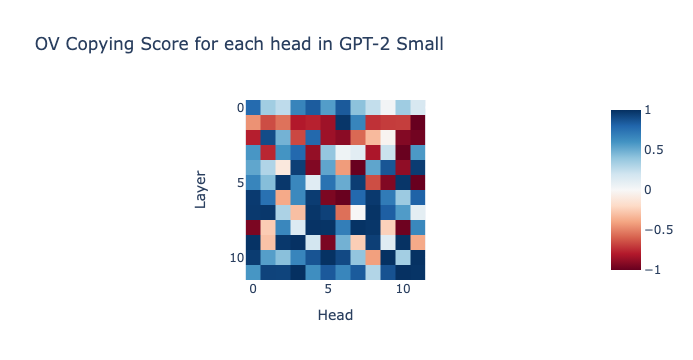

In [67]:
OV_copying_score = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
imshow(utils.to_numpy(OV_copying_score), xaxis="Head", yaxis="Layer", title="OV Copying Score for each head in GPT-2 Small", zmax=1.0, zmin=-1.0)

Head 11 in Layer 11 (L11H11) has a high copying score, and if we plot the eigenvalues they look approximately as expected.

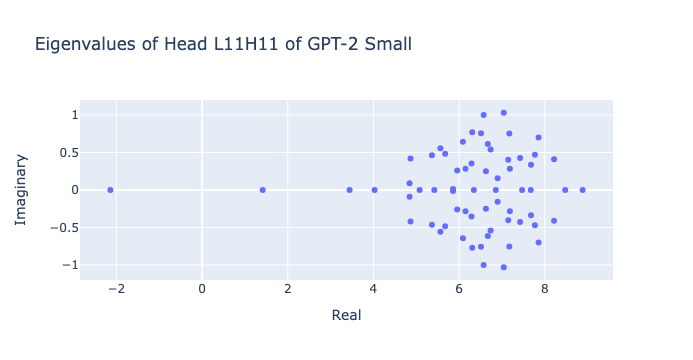

In [68]:
scatter(x=OV_circuit_all_heads_eigenvalues[-1, -1, :].real, y=OV_circuit_all_heads_eigenvalues[-1, -1, :].imag, title="Eigenvalues of Head L11H11 of GPT-2 Small", xaxis="Real", yaxis="Imaginary")

We can even look at the full OV circuit, from the input tokens to output tokens: $W_E W_V W_O W_U$. This is a `[d_vocab, d_vocab]==[50257, 50257]` matrix, so absolutely enormous, even for a single head. But with the FactoredMatrix class, we can compute the full eigenvalue copying score of every head in a few seconds.

In [75]:
full_OV_circuit = model.embed.W_E @ OV_circuit_all_heads @ model.unembed.W_U
print(full_OV_circuit)

FactoredMatrix: Shape(torch.Size([12, 12, 50257, 50257])), Hidden Dim(64)


In [70]:
full_OV_circuit_eigenvalues = full_OV_circuit.eigenvalues
print(full_OV_circuit_eigenvalues.shape)
print(full_OV_circuit_eigenvalues.dtype)

torch.Size([12, 12, 64])
torch.complex64


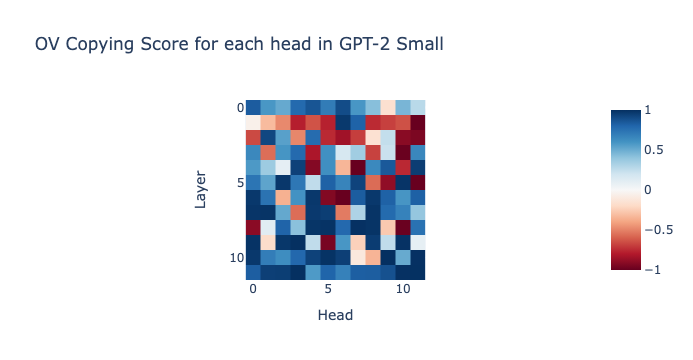

In [71]:
full_OV_copying_score = full_OV_circuit_eigenvalues.sum(dim=-1).real / full_OV_circuit_eigenvalues.abs().sum(dim=-1)
imshow(utils.to_numpy(full_OV_copying_score), xaxis="Head", yaxis="Layer", title="OV Copying Score for each head in GPT-2 Small", zmax=1.0, zmin=-1.0)

Interestingly, these are highly (but not perfectly!) correlated. I'm not sure what to read from this, or what's up with the weird outlier heads!

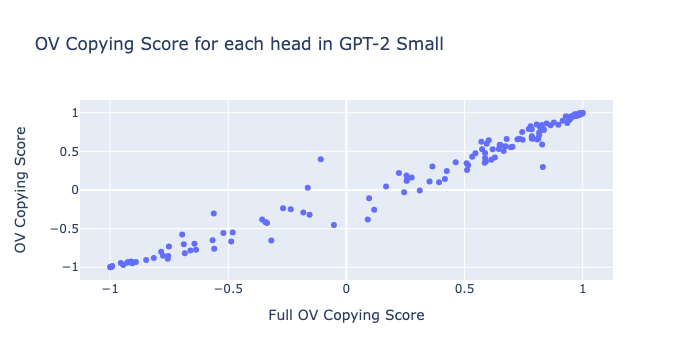

In [72]:
scatter(x=full_OV_copying_score.flatten(), y=OV_copying_score.flatten(), hover_name=[f"L{layer}H{head}" for layer in range(12) for head in range(12)], title="OV Copying Score for each head in GPT-2 Small", xaxis="Full OV Copying Score", yaxis="OV Copying Score")

In [73]:
print(f"Token 256 - the most common pair of ASCII characters: |{model.to_string(256)}|")
# Squeeze means to remove dimensions of length 1. 
# Here, that removes the dummy batch dimension so it's a rank 1 tensor and returns a string
# Rank 2 tensors map to a list of strings
print(f"De-Tokenizing the example tokens: {model.to_string(example_text_tokens.squeeze())}")

Token 256 - the most common pair of ASCII characters: | t|


NameError: name 'example_text_tokens' is not defined

## Generating Text

TransformerLens also has basic text generation functionality, which can be useful for generally exploring what the model is capable of (thanks to Ansh Radhakrishnan for adding this!). This is pretty rough functionality, and where possible I recommend using more established libraries like HuggingFace for this.

In [76]:
model.generate("(CNN) President Barack Obama caught in embarrassing new scandal\n", max_new_tokens=50, temperature=0.7, prepend_bos=True)

  0%|          | 0/50 [00:00<?, ?it/s]

'(CNN) President Barack Obama caught in embarrassing new scandal\n\nif the White House were to allow it. The Obama administration is confronting a scandal that is embarrassing to many Americans, and which is being blamed on a dozen people, including high-ranking officials.\n\nThe scandal began last month when Obama ordered'

## Hook Points

The key part of TransformerLens that lets us access and edit intermediate activations are the HookPoints around every model activation. Importantly, this technique will work for *any* model architecture, not just transformers, so long as you're able to edit the model code to add in HookPoints! This is essentially a lightweight library bundled with TransformerLens that should let you take an arbitrary model and make it easier to study. 

This is implemented by having a HookPoint layer. Each transformer component has a HookPoint for every activation, which wraps around that activation. The HookPoint acts as an identity function, but has a variety of helper functions that allows us to put PyTorch hooks in to edit and access the relevant activation. 

There is also a `HookedRootModule` class - this is a utility class that the root module should inherit from (root module = the model we run) - it has several utility functions for using hooks well, notably `reset_hooks`, `run_with_cache` and `run_with_hooks`. 

The default interface is the `run_with_hooks` function on the root module, which lets us run a forwards pass on the model, and pass on a list of hooks paired with layer names to run on that pass. 

The syntax for a hook is `function(activation, hook)` where `activation` is the activation the hook is wrapped around, and `hook` is the `HookPoint` class the function is attached to. If the function returns a new activation or edits the activation in-place, that replaces the old one, if it returns None then the activation remains as is.


### Toy Example


Here's a simple example of defining a small network with HookPoints:

We define a basic network with two layers that each take a scalar input $x$, square it, and add a constant:
$x_0=x$, $x_1=x_0^2+3$, $x_2=x_1^2-4$.

We wrap the input, each layer's output, and the intermediate value of each layer (the square) in a hook point.



In [77]:

from transformer_lens.hook_points import HookedRootModule, HookPoint


class SquareThenAdd(nn.Module):
    def __init__(self, offset):
        super().__init__()
        self.offset = nn.Parameter(torch.tensor(offset))
        self.hook_square = HookPoint()

    def forward(self, x):
        # The hook_square doesn't change the value, but lets us access it
        square = self.hook_square(x * x)
        return self.offset + square


class TwoLayerModel(HookedRootModule):
    def __init__(self):
        super().__init__()
        self.layer1 = SquareThenAdd(3.0)
        self.layer2 = SquareThenAdd(-4.0)
        self.hook_in = HookPoint()
        self.hook_mid = HookPoint()
        self.hook_out = HookPoint()

        # We need to call the setup function of HookedRootModule to build an
        # internal dictionary of modules and hooks, and to give each hook a name
        super().setup()

    def forward(self, x):
        # We wrap the input and each layer's output in a hook - they leave the
        # value unchanged (unless there's a hook added to explicitly change it),
        # but allow us to access it.
        x_in = self.hook_in(x)
        x_mid = self.hook_mid(self.layer1(x_in))
        x_out = self.hook_out(self.layer2(x_mid))
        return x_out


model = TwoLayerModel()



We can add a cache, to save the activation at each hook point

(There's a custom `run_with_cache` function on the root module as a convenience, which is a wrapper around model.forward that return model_out, cache_object - we could also manually add hooks with `run_with_hooks` that store activations in a global caching dictionary. This is often useful if we only want to store, eg, subsets or functions of some activations.)


In [78]:

out, cache = model.run_with_cache(torch.tensor(5.0))
print("Model output:", out.item())
for key in cache:
    print(f"Value cached at hook {key}", cache[key].item())



Model output: 780.0
Value cached at hook hook_in 5.0
Value cached at hook layer1.hook_square 25.0
Value cached at hook hook_mid 28.0
Value cached at hook layer2.hook_square 784.0
Value cached at hook hook_out 780.0



We can also use hooks to intervene on activations - eg, we can set the intermediate value in layer 2 to zero to change the output to -5


In [79]:

def set_to_zero_hook(tensor, hook):
    print(hook.name)
    return torch.tensor(0.0)


print(
    "Output after intervening on layer2.hook_scaled",
    model.run_with_hooks(
        torch.tensor(5.0), fwd_hooks=[("layer2.hook_square", set_to_zero_hook)]
    ).item(),
)

layer2.hook_square
Output after intervening on layer2.hook_scaled -4.0


## Loading Pre-Trained Checkpoints

There are a lot of interesting questions combining mechanistic interpretability and training dynamics - analysing model capabilities and the underlying circuits that make them possible, and how these change as we train the model. 

TransformerLens supports these by having several model families with checkpoints throughout training. `HookedTransformer.from_pretrained` can load a checkpoint of a model with the `checkpoint_index` (the label 0 to `num_checkpoints-1`) or `checkpoint_value` (the step or token number, depending on how the checkpoints were labelled).


Available models:
* All of my interpretability-friendly models have checkpoints available, including:
    * The toy models - `attn-only`, `solu`, `gelu` 1L to 4L
        * These have ~200 checkpoints, taken on a piecewise linear schedule (more checkpoints near the start of training), up to 22B tokens. Labelled by number of tokens seen.
    * The SoLU models trained on 80% Web Text and 20% Python Code (`solu-6l` to `solu-12l`)
        * Same checkpoint schedule as the toy models, this time up to 30B tokens
    * The SoLU models trained on the pile (`solu-1l-pile` to `solu-12l-pile`)
        * These have ~100 checkpoints, taken on a linear schedule, up to 15B tokens. Labelled by number of steps.
        * The 12L training crashed around 11B tokens, so is truncated.
* The Stanford Centre for Research of Foundation Models trained 5 GPT-2 Small sized and 5 GPT-2 Medium sized models (`stanford-gpt2-small-a` to `e` and `stanford-gpt2-medium-a` to `e`)
    * 600 checkpoints, taken on a piecewise linear schedule, labelled by the number of steps.

The checkpoint structure and labels is somewhat messy and ad-hoc, so I mostly recommend using the `checkpoint_index` syntax (where you can just count from 0 to the number of checkpoints) rather than `checkpoint_value` syntax (where you need to know the checkpoint schedule, and whether it was labelled with the number of tokens or steps). The helper function `get_checkpoint_labels` tells you the checkpoint schedule for a given model - ie what point was each checkpoint taken at, and what type of label was used.

Here are graphs of the schedules for several checkpointed models: (note that the first 3 use a log scale, latter 2 use a linear scale)

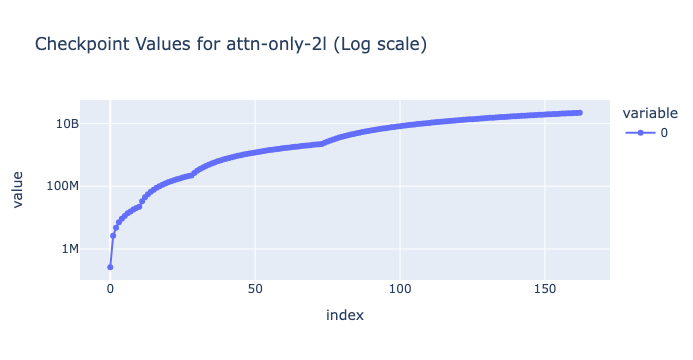

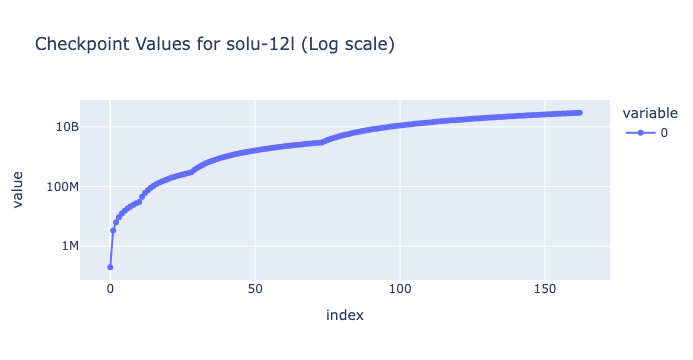

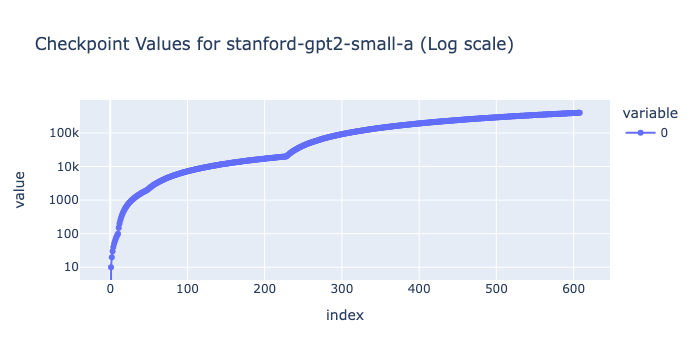

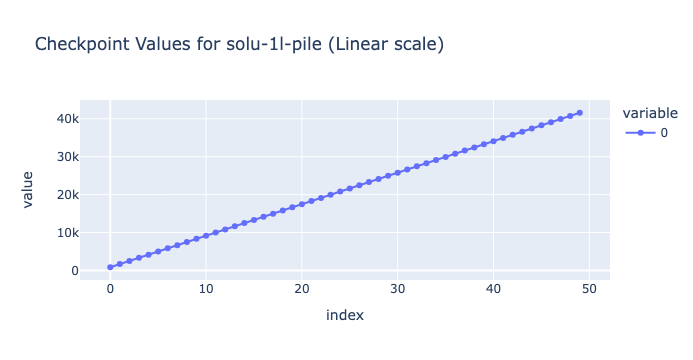

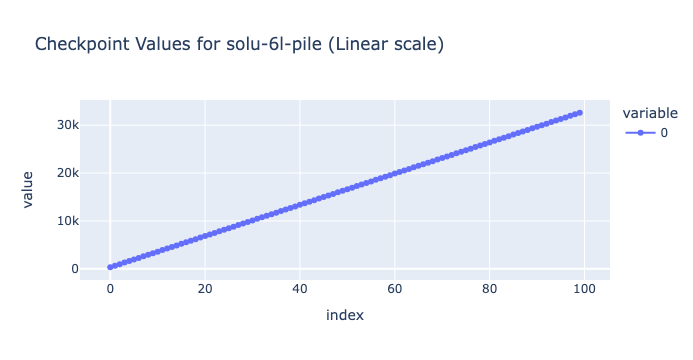

In [80]:
from transformer_lens.loading_from_pretrained import get_checkpoint_labels
for model_name in ["attn-only-2l", "solu-12l", "stanford-gpt2-small-a"]:
    checkpoint_labels, checkpoint_label_type = get_checkpoint_labels(model_name)
    line(checkpoint_labels, xaxis="Checkpoint Index", yaxis=f"Checkpoint Value ({checkpoint_label_type})", title=f"Checkpoint Values for {model_name} (Log scale)", log_y=True, markers=True)
for model_name in ["solu-1l-pile", "solu-6l-pile"]:
    checkpoint_labels, checkpoint_label_type = get_checkpoint_labels(model_name)
    line(checkpoint_labels, xaxis="Checkpoint Index", yaxis=f"Checkpoint Value ({checkpoint_label_type})", title=f"Checkpoint Values for {model_name} (Linear scale)", log_y=False, markers=True)

### Example: Induction Head Phase Transition

One of the more interesting results analysing circuit formation during training is the [induction head phase transition](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html). They find a pretty dramatic shift in models during training - there's a brief period where models go from not having induction heads to having them, which leads to the models suddenly becoming much better at in-context learning (using far back tokens to predict the next token, eg over 500 words back). This is enough of a big deal that it leads to a visible *bump* in the loss curve, where the model's rate of improvement briefly increases. 

As a brief demonstration of the existence of the phase transition, let's load some checkpoints of a two layer model, and see whether they have induction heads. An easy test, as we used above, is to give the model a repeated sequence of random tokens, and to check how good its loss is on the second half. `evals.induction_loss` is a rough util that runs this test on a model.
(Note - this is deliberately a rough, non-rigorous test for the purposes of demonstration, eg `evals.induction_loss` by default just runs it on 4 sequences of 384 tokens repeated twice. These results totally don't do the paper justice - go check it out if you want to see the full results!)

In the interests of time and memory, let's look at a handful of checkpoints (chosen to be around the phase change), indices `[10, 25, 35, 60, -1]`. These are roughly 22M, 200M, 500M, 1.6B and 21.8B tokens through training, respectively. (I generally recommend looking things up based on indices, rather than checkpoint value!). 

In [81]:
from transformer_lens import evals
# We use the two layer model with SoLU activations, chosen fairly arbitrarily as being both small (so fast to download and keep in memory) and pretty good at the induction task.
model_name = "solu-2l"
# We can load a model from a checkpoint by specifying the checkpoint_index, -1 means the final checkpoint
checkpoint_indices = [10, 25, 35, 60, -1]
checkpointed_models = []
tokens_trained_on = []
induction_losses = []

We load the models, cache them in a list, and 

In [82]:
for index in checkpoint_indices:
    # Load the model from the relevant checkpoint by index
    model_for_this_checkpoint = HookedTransformer.from_pretrained(model_name, checkpoint_index=index)
    checkpointed_models.append(model_for_this_checkpoint)

    tokens_seen_for_this_checkpoint = model_for_this_checkpoint.cfg.checkpoint_value
    tokens_trained_on.append(tokens_seen_for_this_checkpoint)

    induction_loss_for_this_checkpoint = evals.induction_loss(model_for_this_checkpoint).item()
    induction_losses.append(induction_loss_for_this_checkpoint)

Loaded pretrained model solu-2l into HookedTransformer


Loaded pretrained model solu-2l into HookedTransformer


Loaded pretrained model solu-2l into HookedTransformer


Loaded pretrained model solu-2l into HookedTransformer


Loaded pretrained model solu-2l into HookedTransformer


We can plot this, and see there's a sharp shift from ~200-500M tokens trained on (note the log scale on the x axis). Interestingly, this is notably earlier than the phase transition in the paper, I'm not sure what's up with that.

(To contextualise the numbers, the tokens in the random sequence are uniformly chosen from the first 20,000 tokens (out of ~48,000 total), so random performance is at least $\ln(20000)\approx 10$. A naive strategy like "randomly choose a token that's already appeared in the first half of the sequence (384 elements)" would get $\ln(384)\approx 5.95$, so the model is doing pretty well here.)

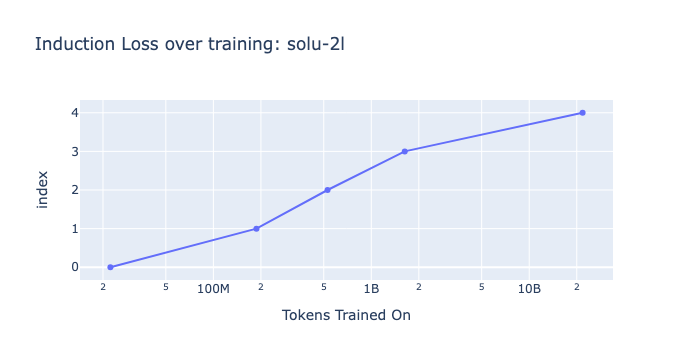

In [85]:
line(induction_losses, x=tokens_trained_on, xaxis="Tokens Trained On", yaxis="Induction Loss", title="Induction Loss over training: solu-2l", markers=True, log_x=True)